mol

C:\ProgramData\Anaconda3\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:263: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


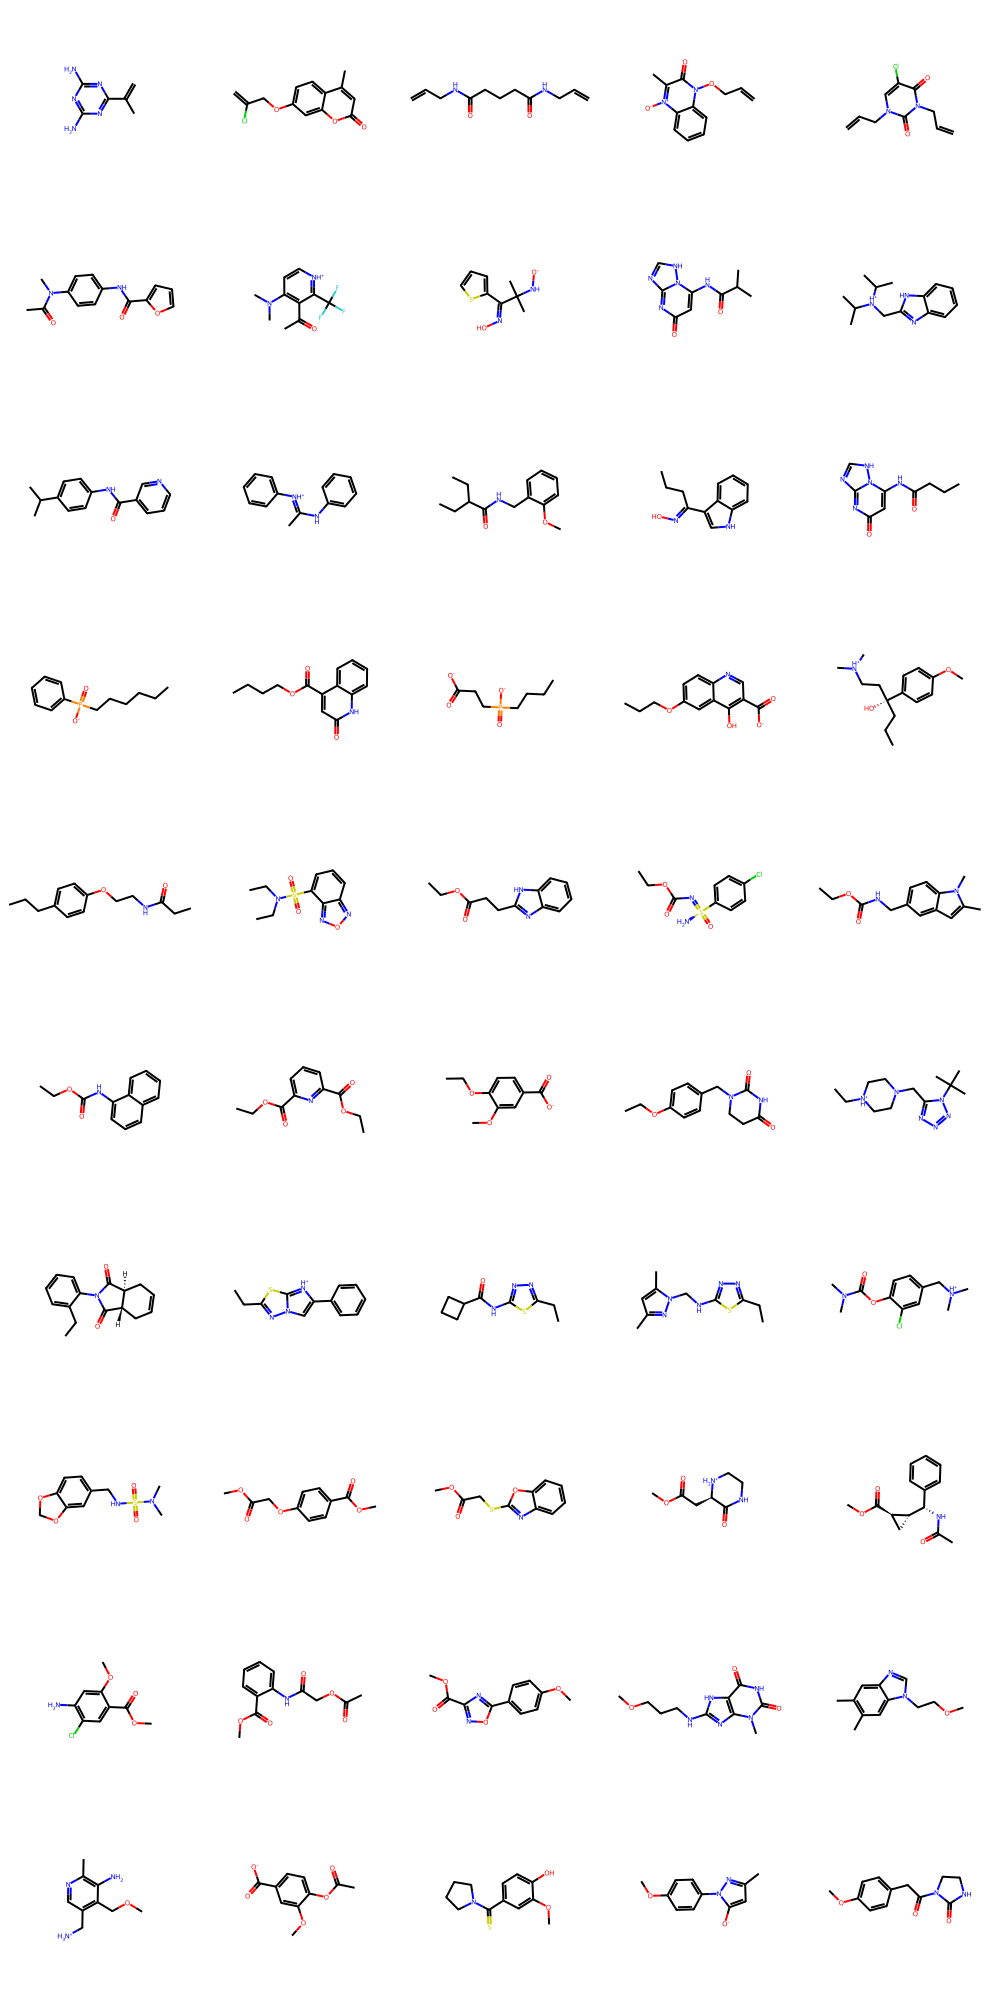

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

# Laad het CSV-bestand
file_path = 'tested_molecules.csv'  # vervang dit met je eigen bestandslocatie
df = pd.read_csv(file_path)

# Converteer de SMILES-strengen naar RDKit-moleculen
df['Molecule'] = df['SMILES'].apply(Chem.MolFromSmiles)

# Visualiseer de eerste 5 moleculen
mols = df['Molecule'].tolist()
img = Draw.MolsToGridImage(mols, molsPerRow=5)
img 

Number of outliers: 20
Outlier molecules:
                                                SMILES
38                         COC(=O)C[C@H]1[NH2+]CCNC1=O
89                Cn1cnc2c1c(=O)n(C[C@H](O)CO)c(=O)n2C
111                       O=C([O-])c1cccc(C(=O)[O-])n1
133  CCC1=C(OC(=O)N(CC)CC)N2C(=O)O/C(=N\Cc3ccccc3)[...
138  CCCCn1c(SCC(=O)Nc2nnc(CC)s2)nc2c1c(=O)n(C)c(=O...
139  CCCN(CCC)C(=O)Cn1c(=O)n(CCCCC(=O)NC2CCCC2)c(=O...
153  CCOCCCNC(=O)[C@H](c1ccccc1)N(Cc1ccc2c(c1)OCO2)...
216  Cc1cc(NC(=O)CSC2=[NH+]c3ccccc3C3=[NH+][C@H](Cc...
229  Cn1c(=O)c2c(nc(C[NH+]3CCN(Cc4ccccc4)CC3)n2CC[N...
230  Cn1c(=O)c2c(nc(C[NH+]3CCN(c4ccccc4)CC3)n2CC[NH...
279   CCCCN(CCCC)S(=O)(=O)c1ccc(C(=O)Nc2nnc(COC)o2)cc1
340  CN1CC[NH+](C[C@H](O)COc2ccc(OC[C@@H](O)C[NH+]3...
411  Cc1[nH]c(=O)[nH]c(=O)c1NC(=O)CSc1ncccc1-c1nc2c...
458  Cn1c(=O)[nH]c(=O)c2c1nc(N1CC[NH+](C)CC1)n2CCSc...
460  Cn1c(=O)c2c(nc(C[NH+]3CCOCC3)n2CC[NH+]2CCOCC2)...
510                C=CCN(CC=C)C(=O)CCCC(=O)N(CC=C)CC=C
768  CC(=O)N[C@@H]1C(=O

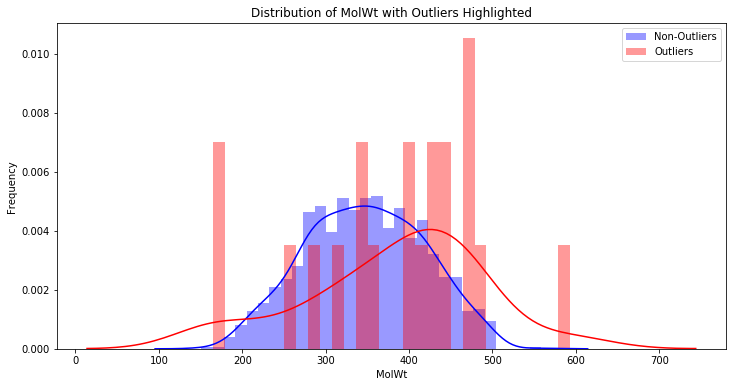

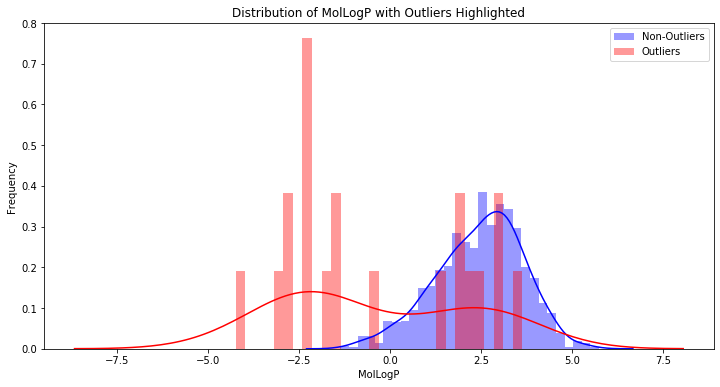

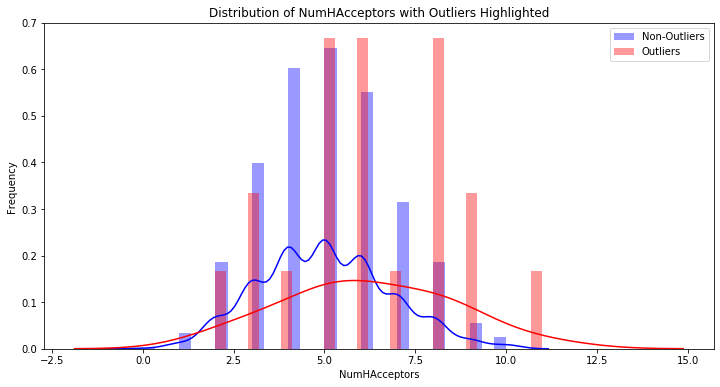

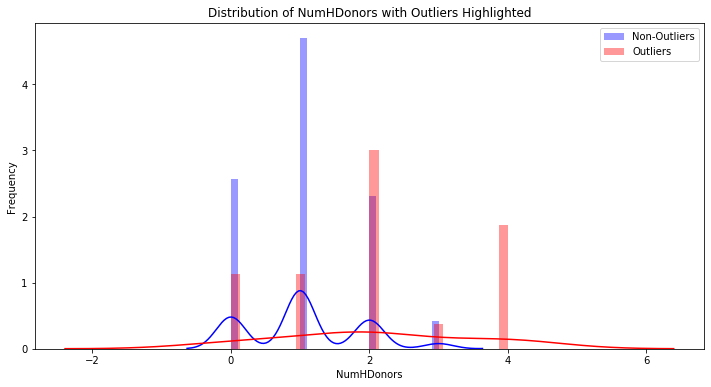

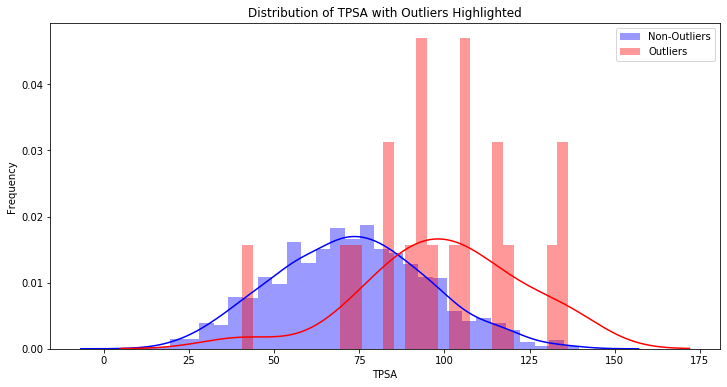

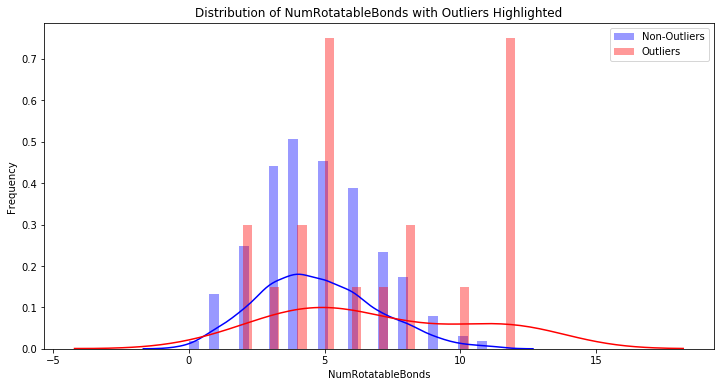

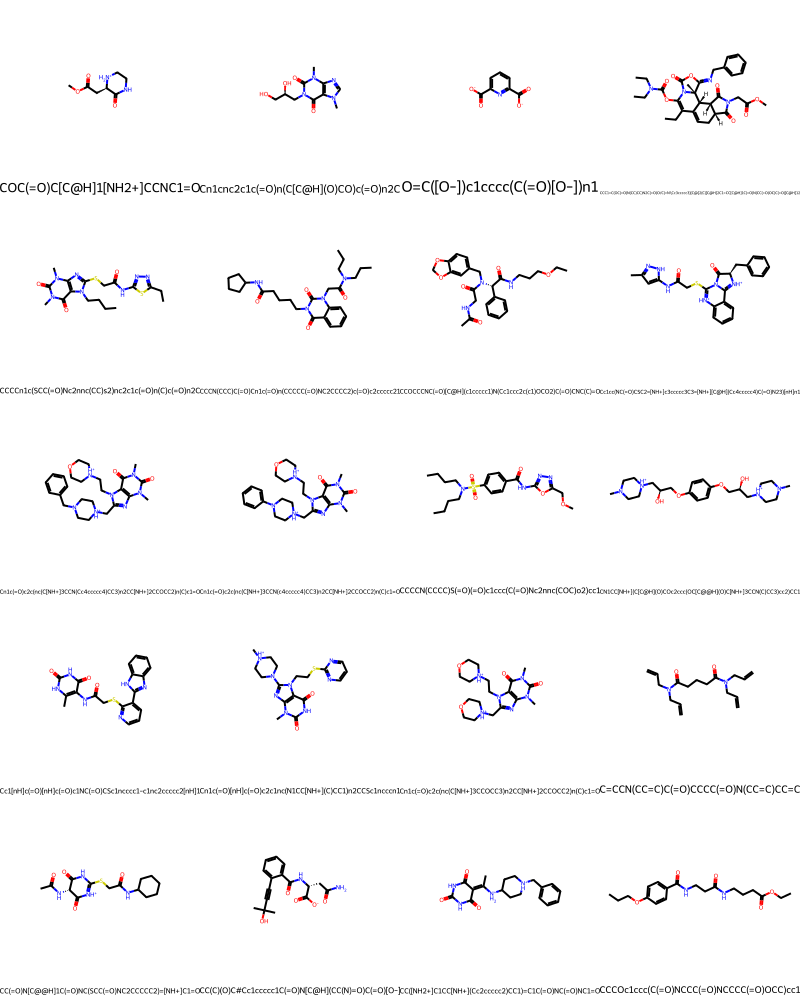

In [2]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Load the dataset
file_path = 'tested_molecules.csv'
molecules_df = pd.read_csv(file_path)

# Function to make the descriptions
def compute_descriptors(smiles):
    molecule = Chem.MolFromSmiles(smiles)
    if molecule is not None:
        descriptors = {
            'MolWt': Descriptors.MolWt(molecule),
            'MolLogP': Descriptors.MolLogP(molecule),
            'NumHAcceptors': Descriptors.NumHAcceptors(molecule),
            'NumHDonors': Descriptors.NumHDonors(molecule),
            'TPSA': Descriptors.TPSA(molecule),
            'NumRotatableBonds': Descriptors.NumRotatableBonds(molecule)
        }
    else:
        descriptors = {
            'MolWt': np.nan,
            'MolLogP': np.nan,
            'NumHAcceptors': np.nan,
            'NumHDonors': np.nan,
            'TPSA': np.nan,
            'NumRotatableBonds': np.nan
        }
    return descriptors

# Compute descriptors for all molecules
descriptors_list = molecules_df['SMILES'].apply(compute_descriptors)
descriptors_df = pd.DataFrame(descriptors_list.tolist())

# Concatenate the descriptors with the original data
molecules_with_descriptors_df = pd.concat([molecules_df, descriptors_df], axis=1)

# Detect the outliers using Z-score
z_scores = descriptors_df.apply(zscore)


threshold = 3  #zscore over 3 is outlier

# put the outliers in a list
outliers = (z_scores.abs() > threshold).any(axis=1)
outlier_molecules = molecules_with_descriptors_df[outliers]
non_outlier_molecules = molecules_with_descriptors_df[~outliers]

# Print the number of outliers
num_outliers = outliers.sum()
print(f"Number of outliers: {num_outliers}")
print("Outlier molecules:")
print(outlier_molecules[['SMILES']])

# Plotting distributions with the outliers an other color
def plot_descriptor_distribution(descriptor_name):
    plt.figure(figsize=(12, 6))
    sns.distplot(non_outlier_molecules[descriptor_name].dropna(), bins=30, kde=True, label='Non-Outliers', color='blue')
    sns.distplot(outlier_molecules[descriptor_name].dropna(), bins=30, kde=True, label='Outliers', color='red')
    plt.xlabel(descriptor_name)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {descriptor_name} with Outliers Highlighted')
    plt.legend()
    plt.show()

# List of descriptors to plot
descriptors_to_plot = ['MolWt', 'MolLogP', 'NumHAcceptors', 'NumHDonors', 'TPSA', 'NumRotatableBonds']

# Plot each descriptor
for descriptor in descriptors_to_plot:
    plot_descriptor_distribution(descriptor)

# Display structures of outlier molecules
outlier_smiles = outlier_molecules['SMILES'].tolist()
outlier_mols = [Chem.MolFromSmiles(smiles) for smiles in outlier_smiles]
img = Draw.MolsToGridImage(outlier_mols, molsPerRow=4, subImgSize=(200, 200), legends=outlier_smiles)
img